<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Important-Scripts" data-toc-modified-id="Important-Scripts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Important Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Log-transform-large-values" data-toc-modified-id="Log-transform-large-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Log transform large values</a></span></li><li><span><a href="#Train-Test-split-after-log-transform" data-toc-modified-id="Train-Test-split-after-log-transform-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train-Test split after log transform</a></span></li><li><span><a href="#Scaling-the-Data" data-toc-modified-id="Scaling-the-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scaling the Data</a></span></li><li><span><a href="#GBR-Modelling" data-toc-modified-id="GBR-Modelling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>GBR Modelling</a></span></li><li><span><a href="#GBR-modelling-using-pipeline" data-toc-modified-id="GBR-modelling-using-pipeline-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>GBR modelling using pipeline</a></span></li><li><span><a href="#Cross-Validation-Results" data-toc-modified-id="Cross-Validation-Results-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Cross Validation Results</a></span></li><li><span><a href="#HPO-(Hyper-Parameters-Optimization)" data-toc-modified-id="HPO-(Hyper-Parameters-Optimization)-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>HPO (Hyper Parameters Optimization)</a></span><ul class="toc-item"><li><span><a href="#Grid-Search-for-Gradient-Boosting-Regressor" data-toc-modified-id="Grid-Search-for-Gradient-Boosting-Regressor-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Grid Search for Gradient Boosting Regressor</a></span></li><li><span><a href="#Best-Model" data-toc-modified-id="Best-Model-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Best Model</a></span></li></ul></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

This dataset contains house sale prices for King County,
which includes Seattle.
It includes homes sold between May 2014 and May 2015.

- Dependent features: 1 (price)
- Features : 19 home features
- Id:  1 house ID

Task: Try to estimate the price based on given features.

![](https://github.com/bhishanpdl/Project_House_Price_Prediction/blob/master/data/raw/data_description.png?raw=1)

# Imports

In [1]:
import time
time_start_notebook = time.time()

In [2]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install watermark
    !pip install catboost
    !pip install shap eli5

    # if we update existing module, we need to restart colab
    !pip install -U scikit-learn

    ## print
    print('Environment: Google Colaboratory.')
TREE_METHOD = 'gpu_hist' if ENV_COLAB else 'auto'

In [3]:
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
from pprint import pprint

# random state
SEED=100
np.random.seed(SEED)

# settings
pd.set_option('display.max_columns', 200)

# sklearn
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# boosting
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost
import lightgbm
import catboost
import xgboost as xgb
import lightgbm as lgb
import catboost as catb

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-11-05 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

watermark  2.0.2
seaborn    0.11.0
xgboost    0.90
matplotlib 3.2.2
lightgbm   2.2.3
numpy      1.18.5
catboost   0.24.2
pandas     1.1.4
sklearn    0.23.2



# Important Scripts

In [4]:
def show_methods(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [5]:
def adjustedR2(rsquared,nrows,ncols):
    return rsquared- (ncols-1)/(nrows-ncols) * (1-rsquared)

In [6]:
def print_regr_eval(ytest,ypreds,ncols,log_back=False):
    # if we have done log1p to Xtrain, then model.predict(Xtest) will give 
    # logged target, we need to get it back
    if log_back:
        ypreds = np.expm1(ypreds)

    rmse = np.sqrt(metrics.mean_squared_error(ytest,ypreds))
    r2 = metrics.r2_score(ytest,ypreds)
    ar2 = adjustedR2(r2,len(ytest),ncols)
    evs = metrics.explained_variance_score(ytest, ypreds)

    print('ytest :', ytest[:3])
    print('ypreds:', ypreds[:3])

    print(f"""           
Explained Variance: {evs:.6f}
         R-Squared: {r2:,.6f}

             RMSE : {rmse:,.2f}
Adjusted R-squared: {ar2:,.6f}

""")
    
def plot_xgb_cv_res(df_cv_results):
    fig,ax = plt.subplots()
    plt.plot(df_cv_results['train-rmse-mean'],color='b',label='train-rmse')
    plt.plot(df_cv_results['test-rmse-mean'],color='r',label='train-rmse')
    plt.title('Cross validation score mean plot',fontsize=14)
    plt.legend()
    plt.show()

# Parameters

In [7]:
if ENV_COLAB:
    path_raw = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/'
    proj = 'Projects/King_County_Seattle_House_Price_Kaggle/'
    data_path_parent = path_raw + proj
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

else:
    data_path_parent = '../data/'
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

target = 'price'
train_size = 0.8

print(data_path_train)

https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/King_County_Seattle_House_Price_Kaggle/raw/train.csv


# Load the data

In [8]:
df_train_raw = pd.read_csv(data_path_train)
df_test_raw = pd.read_csv(data_path_test)
print(df_train_raw.shape)
print(df_train_raw.columns)

display(df_train_raw.head(2).append(df_train_raw.tail(2)))

(17290, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2561340020,20140804T000000,325000.0,3,1.75,1780,11096,1.0,0,0,3,7,1210,570,1979,0,98074,47.6170,-122.051,1780,10640
1,8598200070,20141208T000000,278000.0,2,2.50,1420,2229,2.0,0,0,3,7,1420,0,2004,0,98059,47.4871,-122.165,1500,2230
17288,7174800760,20140725T000000,667000.0,5,2.00,1900,5470,1.0,0,0,3,7,1180,720,1930,1965,98105,47.6666,-122.303,1300,3250
17289,9521100280,20140612T000000,480000.0,3,2.50,1250,1103,3.0,0,2,3,8,1250,0,2005,0,98103,47.6619,-122.352,1250,1188


# Data Processing

## Drop unwanted features

In [9]:
cols_drop = ['id','date']
df_train = df_train_raw.drop(cols_drop,axis=1)
df_test = df_test_raw.drop(cols_drop,axis=1)

# Log transform large values

In [10]:
cols_log = ['sqft_living','sqft_living15','sqft_lot','sqft_lot15']

for col in cols_log:
    df_train[col] = np.log1p(df_train[col].to_numpy())
    df_test[col] = np.log1p(df_test[col].to_numpy())

## Log transform target of training data (we need to get back later)

In [11]:
# we dont change test dataset target, only change training data
df_train[target] = np.log1p(df_train[target])

## Create squared features

In [31]:
## NOTE: This gave me worse result
## squared features is bad.


# # squared columns
# cols_sq = ['bedrooms','bathrooms','floors','waterfront','view']
# cols_sq = cols_sq + cols_log

# for col in cols_sq:
#     df_train[col + '_sq'] = df_train[col]**2
#     df_test[col + '_sq'] = df_test[col]**2

## Feature selection

In [32]:
features_raw_all = list(df_train.columns.drop(target))

dict_features = dict(enumerate(features_raw_all))
print(features_raw_all)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [14]:
features = features_raw_all

# Train validation split

In [15]:
df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = model_selection.train_test_split(
    df_train.drop(target,axis=1), df_train[target],
    train_size=0.8, random_state=SEED)

ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()

df_Xtest = df_test[features]
ytest = np.array(df_test[target]).flatten()

print(f"df_train   : {df_train.shape}\n")

print(f"df_Xtrain  : {df_Xtrain.shape}")
print(f"ser_ytrain : {ser_ytrain.shape}\n")

print(f"df_Xvalid  : {df_Xvalid.shape}")
print(f"ser_yvalid : {ser_yvalid.shape}\n")

print(f"df_test    : {df_test.shape}")
print(f"ser_ytest  : This does not exist.")

df_Xtrain.head(2)

df_train   : (17290, 19)

df_Xtrain  : (13832, 18)
ser_ytrain : (13832,)

df_Xvalid  : (3458, 18)
ser_yvalid : (3458,)

df_test    : (4323, 19)
ser_ytest  : This does not exist.


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13832,5,3.0,8.243019,10.652944,1.5,0,0,4,9,3800,0,1984,0,98042,47.3488,-122.095,7.855932,10.485033
4184,3,2.5,7.890208,8.517393,2.0,0,3,5,9,2000,670,1942,1995,98144,47.5855,-122.292,7.749753,8.517393


## Scaling

In [16]:
scaling = None # standard gave me worse result

if scaling == 'standard':
    scaler = preprocessing.StandardScaler()
    scaler.fit(df_Xtrain)
    df_Xtrain = pd.DataFrame(scaler.transform(df_Xtrain),columns=features)
    df_Xvalid =  pd.DataFrame(scaler.transform(df_Xvalid),columns=features)
    df_Xtest =  pd.DataFrame(scaler.transform(df_Xtest),columns=features)
elif scaling == 'minmax':
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(df_Xtrain)
    df_Xtrain = pd.DataFrame(scaler.transform(df_Xtrain),columns=features)
    df_Xvalid = pd.DataFrame(scaler.transform(df_Xvalid),columns=features)
    df_Xtest =  pd.DataFrame(scaler.transform(df_Xtest),columns=features)

df_Xtrain.head(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13832,5,3.0,8.243019,10.652944,1.5,0,0,4,9,3800,0,1984,0,98042,47.3488,-122.095,7.855932,10.485033
4184,3,2.5,7.890208,8.517393,2.0,0,3,5,9,2000,670,1942,1995,98144,47.5855,-122.292,7.749753,8.517393


## Create lgb Dataset

In [17]:
print(df_Xtrain.columns)
df_Xtrain.head(2)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13832,5,3.0,8.243019,10.652944,1.5,0,0,4,9,3800,0,1984,0,98042,47.3488,-122.095,7.855932,10.485033
4184,3,2.5,7.890208,8.517393,2.0,0,3,5,9,2000,670,1942,1995,98144,47.5855,-122.292,7.749753,8.517393


In [18]:
cols_cat = ['bedrooms', 'bathrooms', 'floors',
       'waterfront', 'view', 'condition', 'grade']

df_train[cols_cat].apply(pd.Series.nunique)

bedrooms      13
bathrooms     29
floors         6
waterfront     2
view           5
condition      5
grade         12
dtype: int64

In [19]:
categorical_feature = cols_cat
dtrain = lgb.Dataset(df_Xtrain,ytrain,
                     free_raw_data=False,
                     categorical_feature=categorical_feature
                     ) 

dvalid = lgb.Dataset(df_Xvalid,yvalid,
                     free_raw_data=False,
                     reference=dtrain
                     )
type(dtrain)

lightgbm.basic.Dataset

# Modelling: lightgbm (lgb api)
- [lightgbm metrics](https://testlightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters)

## Baseline model

In [20]:
# params
params = {
    'objective'        : 'regression', # regression binary etc
    'metric'           : ['mae','mse','rmse','mape'],
    'num_leaves'       : 200,
    'max_depth'        : 15,
    'learning_rate'    : 0.01,
    'feature_fraction' : 0.6,
    'verbosity'        : -1
}


num_boost_round = 500_000
evals_result    = {}  # similar to keras history, stores fitting history


model_lgb = lgb.train(params,dtrain,num_boost_round,
    valid_sets=[dtrain, dvalid],
    valid_names=["train", "valid"],
    evals_result=evals_result,
    early_stopping_rounds=50, # choose num_boost_round much larger than this
    verbose_eval=500          # print every nth interval
)

# model evaluation
ypreds = model_lgb.predict(df_Xtest)
print_regr_eval(ytest,ypreds,ncols=len(features),log_back=True)

Training until validation scores don't improve for 50 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'view', 'waterfront']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	train's rmse: 0.114881	train's l2: 0.0131975	train's mape: 0.00634853	train's l1: 0.0822892	valid's rmse: 0.167371	valid's l2: 0.0280131	valid's mape: 0.00909549	valid's l1: 0.11854
[1000]	train's rmse: 0.0893544	train's l2: 0.00798422	train's mape: 0.00492827	train's l1: 0.06377	valid's rmse: 0.164218	valid's l2: 0.0269677	valid's mape: 0.00888111	valid's l1: 0.115677
Early stopping, best iteration is:
[1045]	train's rmse: 0.0877693	train's l2: 0.00770345	train's mape: 0.0048365	train's l1: 0.0625752	valid's rmse: 0.164126	valid's l2: 0.0269375	valid's mape: 0.00887485	valid's l1: 0.115592
ytest : [285000. 239950. 460000.]
ypreds: [325229.13862974 225351.23785385 557709.56466719]
           
Explained Variance: 0.896250
         R-Squared: 0.895164

             RMSE : 118,864.00
Adjusted R-squared: 0.894750




## Model convergence

In [21]:
pd.DataFrame(evals_result).head()

,train,valid
rmse,"[0.5218880782319588, 0.5178056183579268, 0.513...","[0.5221413773134713, 0.5181144082389141, 0.514..."
l2,"[0.2723671662006472, 0.268122658403035, 0.2638...","[0.2726316179028088, 0.26844254002476015, 0.26..."
mape,"[0.031362807156483055, 0.03111190307980371, 0....","[0.031090890818884064, 0.03084514475931795, 0...."
l1,"[0.4097169239562145, 0.4064353901654512, 0.403...","[0.40761931188906214, 0.40439529429253385, 0.4..."


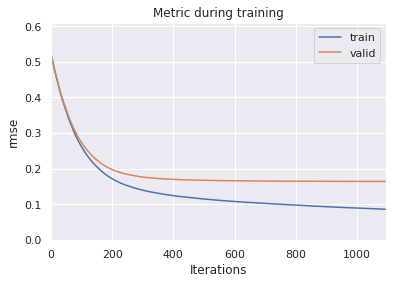

In [22]:
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

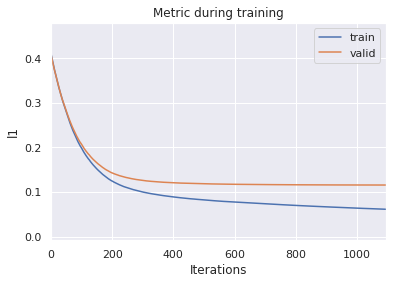

In [23]:
ax = lgb.plot_metric(evals_result, metric='l1') # mae is l1 and mse is l2
plt.show()

## Feature Importance

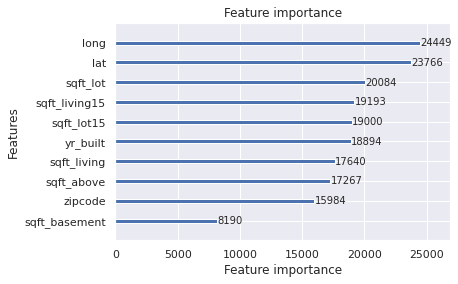

In [24]:
ax = lgb.plot_importance(model_lgb, max_num_features=10)
plt.show()

## Cross validation

In [25]:
# help(lgb.cv)

In [26]:
# params
params_small = {'num_leaves':300,
          'objective':'regression', # use binary for classification
          'max_depth':7,
          'learning_rate':.05,
          'max_bin':200,
          'min_data_in_leaf': 10,
          'random_state': SEED,
          'metric': ['rmse', 'mae','mape','auc']
          }


num_boost_round = 10_000
n_folds = 5
cv_results = lgb.cv(params_small, 
                    dtrain,
                    num_boost_round=num_boost_round,
                    nfold = n_folds,
                    stratified=False, # needed for regression
                    shuffle=True,
                    early_stopping_rounds = 100, 
                    metrics = 'rmse', 
                    seed = SEED)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [27]:
type(cv_results)

dict

In [28]:
cv_results.keys()

dict_keys(['rmse-mean', 'rmse-stdv'])

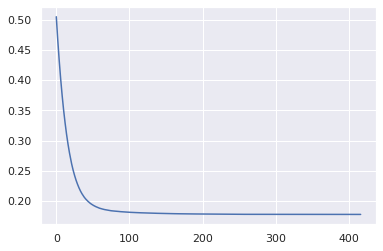

In [29]:
plt.plot(cv_results['rmse-mean'])

# Time Taken

In [30]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 0 min 35 secs
